# Using Yelp Data to Recommend the Location of the Next Lou Malnati : Data Prep
Chicago pizza magnate Lou Malnati is looking to expand his national pizza empire. With 59 locations in Illinois, seven in Arizona, four in Wisconsin, and four in Indiana, Malnati is interested in expanding both within Arizona and Indiana and to other states. In particular, Malnati is interested in Florida, Pennsylvania, New Jersey, and Missouri. 
Malnati’s restaurants are known for their deep dish pizza, and are looking for locations that either might not have deep dish options or locations where the pizza options are not satisfying consumers. Malnati's team believes that they can both introduce deep dish to new customers and lure currently unsatisfied customers with their nationally recognized pizza brand. 
Malnati’s team has requested an analysis of the existing landscape in the four new states along with Arizona and Missouri. They want to understand which state holds the most promise for more or more new locations. Ideally, they would like to open up multiple locations and want to know whether one of the new states would be a better option than continuing to open up restaurants in Arizona and Missouri.

**The purpose of this notebook is to convert the provided JSON data into pandas dataframes and then determine which of the various categories to focus on in the project analysis.**

## Data Sources
All data has been downloaded directly from [Yelp](https://www.yelp.com/dataset):

1. yelp_academic_dataset_business.json: contains business data including location data, attributes, and categories
2. yelp_academic_dataset_review.json: contains full review text data including the user_id that wrote the review and the business_id the review is written for.



## Changes
- 03-02-22: Started project
- 03-5-22: View categories of businesses and select businesses categories to see cities; determine number of reviews for each business category
- 03-6-22: Revise overview of project 

## Import Libraries

In [91]:
import pandas as pd
import json
import string
import os
import re
import plotly.express as px
import matplotlib.pyplot as plt

## File Locations

In [2]:
business_json = '../data/raw/yelp_academic_dataset_business.json'

review_json = '../data/raw/yelp_academic_dataset_review.json'

business_pkl_df = '..data/interim/business.pkl'
review_pkl_df = '..data/interim/review.pkl'

## Load Data
Loading JSON data, converting to pandas dataframe, and pickling adapted from https://github.com/nhcamp/Yelp-Burrito-Reviews/blob/master/Capstone%202.ipynb

In [3]:
business = pd.read_json(business_json, lines='True')

## Business Data: What is the distribution of types of businesses in the dataset?

In [4]:
# Convert the JSON data to a pandas df
business_df = pd.DataFrame(business)

In [5]:
# Determine which features have null values
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [6]:
# Determine the number of unique businesses
business_df['business_id'].nunique()

150346

In [7]:
# Determine the number of unique category sets
business_df['categories'].nunique()

83160

<div class="alert alert-block alert-info">
Reviewing the data, there are 150,346 records. However, <b>given that we want to understand the distribution of categories, we need to only keep the records with a category (150,243)</b>. Additionally, the category feature currently includes multiple categories (e.g., pizza, restuarant, Italian) for each record. To get a more accurate distribution, we need to consider each category separately (i.e., while there are 83,160 unique category sets, how many unique categories are there total?).
</div>

In [8]:
# Keep only records with non-null values for "categories"
business_df = business_df[business_df['categories'].notna()]

In [9]:
# Determine the number of unique businesses after the filtering
business_df['business_id'].nunique()

150243

In [10]:
# Create a list of strings that contain the categories in each record
category_groups = list(business_df['categories'].explode())

In [11]:
# Convert category groups into a list of lists so that each category is now a single string
all_categories = []

for i in range(0,len(category_groups)):
    all_categories.append(category_groups[i].split(','))

In [12]:
# Flatten the list of lists in a single list of the categories
all_categories = [categories for sublist in all_categories for categories in sublist]

In [13]:
# Convert the list to a pandas df
all_categories_df = pd.DataFrame(all_categories, columns=['Categories'])

In [14]:
# Strip whitespace
all_categories_df['Categories'] = all_categories_df['Categories'].str.strip()

In [15]:
# Determine how many unique categories in the dataset
all_categories_df['Categories'].nunique()

1311

In [16]:
# Determine the total number of records
all_categories_df['Categories'].shape

(668592,)

<div class="alert alert-block alert-info">
There appeared to be 2454 unique categories, however after stripping away whitespace, there are only 1,311 unique categories. <b>Thus, there are 668,592 records with 1,311 unique categories</b>. Now, the number of businesses within each category can be determined.
</div>

In [25]:
# Determine the top 10 categories
category_counts = pd.DataFrame(all_categories_df['Categories'].value_counts()).reset_index().rename(columns={'index': 'Category',
                                                                                                            'Categories': 'Count'})
category_counts.head(30)

,Category,Count
0,Restaurants,52268
1,Food,27781
2,Shopping,24395
3,Home Services,14356
4,Beauty & Spas,14292
5,Nightlife,12281
6,Health & Medical,11890
7,Local Services,11198
8,Bars,11065
9,Automotive,10773


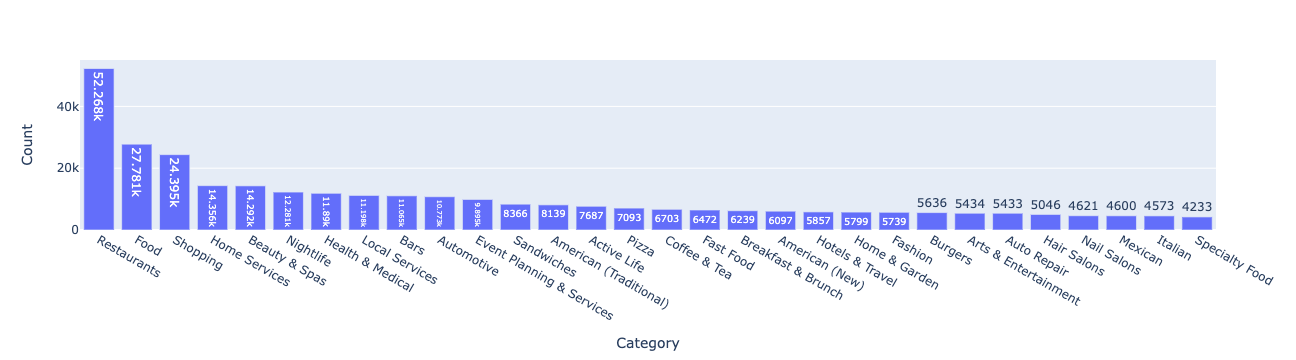

In [102]:
# Plot the top thirty categories
fig = px.bar(category_counts.head(30), x='Category', y='Count', text_auto=True)
fig.show()

In [31]:
# Identify the number of sushi businesses
category_counts[category_counts['Category'].str.contains('Sushi')]

,Category,Count
73,Sushi Bars,1717
1268,Conveyor Belt Sushi,1


<div class="alert alert-block alert-info">
In the top 30 categories, restaurants is by far the most common category with 52,268 businesses. Food comes second with 27,781 businesses; shopping is third with 24,395 businesses. <b>However, these categories are far too broad when considering the problem of opening a new restaurant</b>. Pizza might be a good option 7,093 businesses, however it is not clear how many states and cities the businesses are in that are in the pizza category. Sushi might also be an option with 1,718 businesses.
</div>

## Business Data: For pizza and sushi businesses, how many states and cities are they located in?

In [42]:
#Identify the number of businesses that have a pizza catergory
pizza_businesses = business_df[business_df['categories'].str.contains('Pizza')]
pizza_states = pizza_businesses['state'].nunique()
pizza_cities = pizza_businesses['city'].nunique()
print('There are a total of', pizza_businesses.shape[0], 'pizza businesses in', pizza_states, 'states and', pizza_cities, 'cities.')

There are a total of 7093 pizza businesses in 15 states and 556 cities.


In [88]:
# Determine the states in which the pizza businesses are located
pizza_states_counts = pizza_businesses.groupby('state')['business_id'].nunique().sort_values(ascending = False)

In [97]:
# Create a dataframe for the pizza counts by state
pizza_states_counts = pd.DataFrame(pizza_states_counts).reset_index()

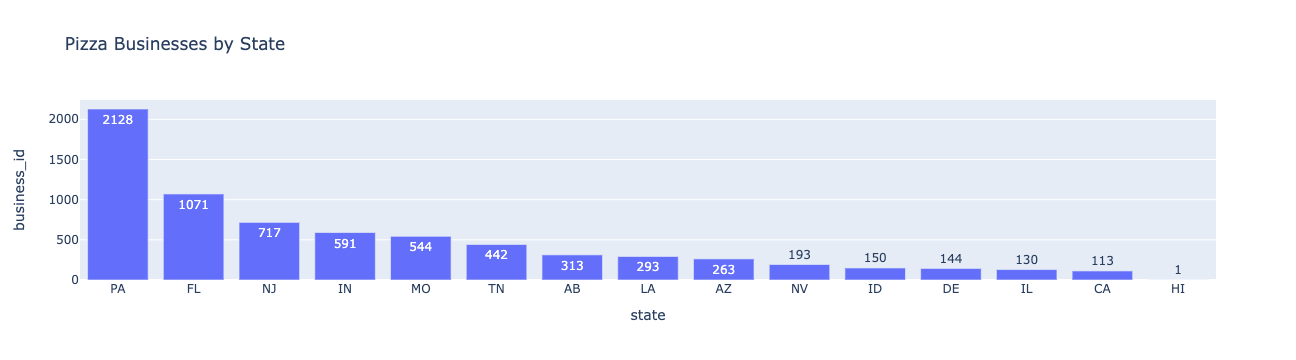

In [107]:
# Plot the states for pizza locations
fig = px.bar(pizza_states_counts, x='state', y='business_id', text_auto=True, title = 'Pizza Businesses by State')
fig.show()

In [41]:
#Identify the number of businesses that have a sushi catergory
sushi_businesses = business_df[business_df['categories'].str.contains('Sushi')]
sushi_states = sushi_businesses['state'].nunique()
sushi_cities = sushi_businesses['city'].nunique()
print('There are a total of', sushi_businesses.shape[0], 'sushi businesses in', sushi_states, 'states and', sushi_cities, 'cities.')

There are a total of 1718 sushi businesses in 14 states and 265 cities.


In [103]:
# Determine the states in which the sushi businesses are located
sushi_states_counts = sushi_businesses.groupby('state')['business_id'].nunique().sort_values(ascending = False)

In [104]:
# Create a dataframe for the sushi counts by state
sushi_states_counts = pd.DataFrame(sushi_states_counts).reset_index()

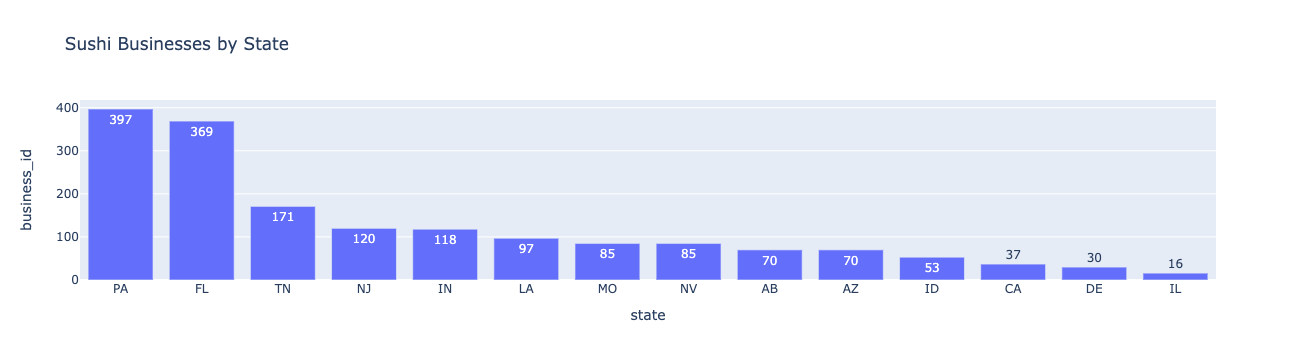

In [106]:
# Plot the states for sushi locations
fig = px.bar(sushi_states_counts, x='state', y='business_id', text_auto=True, title = 'Sushi Businesses by State')
fig.show()

## Identify Business IDs for Selection Group

In [57]:
# Create a dictionary of pizza business IDs and names and a list of business IDs (adapted from https://github.com/nhcamp/Yelp-Burrito-Reviews/blob/master/Capstone%202.ipynb)
pizza_tags_dict = {}
pizza_tags_id = []

for index,data in pizza_businesses.iterrows():
    pizza_tags_dict[data['business_id']] = data['name']
    pizza_tags_id.append(data['business_id'])

In [58]:
# Read in the reviews JSON data
reviews = []

with open(review_json, 'r') as fp:
    for line in fp:
        comment = json.loads(line) 
        reviews.append(comment)
    fp.close()

In [65]:
# Determine number of reviews
print('There are', len(reviews), 'reviews.')

There are 6990280 reviews.


In [70]:
# Create a pandas df of the reviews
reviews_df = pd.DataFrame(reviews)

In [75]:
# Identify the reviews specific for pizza
pizza_business_ids = list(pizza_businesses['business_id'].unique())
pizza_reviews = reviews_df[reviews_df['business_id'].isin(pizza_business_ids)]

In [78]:
# Identify the number of reviews for pizza
print('There are', pizza_reviews['review_id'].nunique(), 'unique reviews about the pizza businesses.')

There are 475819 unique reviews about the pizza businesses.


In [79]:
# Identify the reviews specific for sushi
sushi_business_ids = list(sushi_businesses['business_id'].unique())
sushi_reviews = reviews_df[reviews_df['business_id'].isin(sushi_business_ids)]

In [80]:
# Identify the number of reviews for sushi
print('There are', sushi_reviews['review_id'].nunique(), 'unique reviews about the sushi businesses.')

There are 226008 unique reviews about the sushi businesses.


<div class="alert alert-block alert-info">
After filtering the reviews for pizza and sushi data, there are <b>475,819 reviews for pizza businesses and 226,008 reviews for sushi businesses</b>.
</div>